In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

import numpy as np
np.random.seed = 42

import seaborn as sns

import pandas as pd

import matplotlib.pyplot as plt

import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization, Input, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from keras_tuner import HyperParameters, Hyperband

from os.path import isfile

import lzma

import pickle

In [2]:
BATCH_SIZE = 32

**Импорт данных**

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

**Визуализация исходных данных**

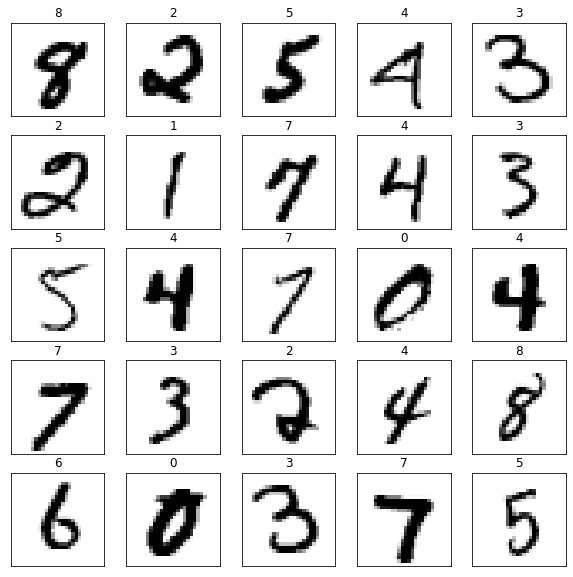

In [4]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10))
axs = ax.flatten()

letters_idx = np.random.randint(0, X_test.shape[0], len(axs))

for idx in range(len(axs)):
    axs[idx].imshow(X_test[letters_idx[idx]], cmap='gray_r')
    axs[idx].set_title(y_test[letters_idx[idx]])
    axs[idx].xaxis.set_ticks([])
    axs[idx].yaxis.set_ticks([])

plt.show()


In [5]:
width, height, depth = X_train.shape[1], X_train.shape[2], 1

X_train = X_train.reshape(X_train.shape[0], width, height, depth)
X_train = X_train.astype(np.float32)

X_test = X_test.reshape(X_test.shape[0], width, height, depth)
X_test = X_test.astype(np.float32)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

**Аугментация**

Мне показалось скучным работать с исходными данными - слишком они хороши. 

In [6]:
W_SHIFT = [-1, 1]
H_SHIFT = [-1, 1]
ROT_ANGLE = 20
ZOOM_RANGE = [0.7, 1.2]

Я много раз читал о создании валидационного датасета, который является частью тренировочного. Лучше один раз сделать, чем сто раз прочитать.

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train)

В принципе, генератор можно настроить на разделение датасета. Чтобы не делать несколько отдельных. Но мне показалось так интереснее. Серьезного обоснования такому решению нет.

In [8]:
train_generator = ImageDataGenerator(
    width_shift_range=W_SHIFT, 
    height_shift_range=H_SHIFT,
    rotation_range=ROT_ANGLE,
    zoom_range=ZOOM_RANGE,
    samplewise_center=True,
    samplewise_std_normalization=True,
    rescale= 1.0/255.0
)

train_generator.fit(X_train)
train_iterator = train_generator.flow(X_train, y_train, batch_size=BATCH_SIZE)

In [9]:
val_generator = ImageDataGenerator(
    width_shift_range=W_SHIFT, 
    height_shift_range=H_SHIFT,
    rotation_range=ROT_ANGLE,
    zoom_range=ZOOM_RANGE,
    samplewise_center=True,
    samplewise_std_normalization=True,
    rescale= 1.0/255.0
)

val_generator.fit(X_val)
val_iterator = val_generator.flow(X_val, y_val, batch_size=BATCH_SIZE)

In [10]:
test_generator = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    rescale=1.0/255.0
)

test_generator.fit(X_test)
test_iterator = test_generator.flow(X_test, y_test, batch_size=1)

**Визуализация аугментированных данных**

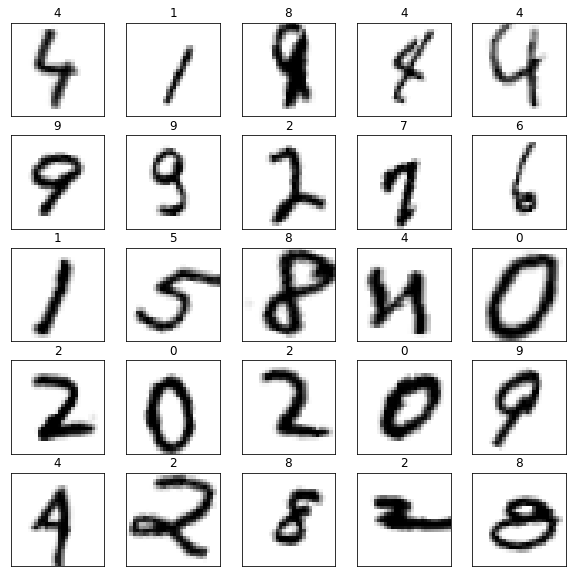

In [11]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10))
axs = ax.flatten()

for idx in range(len(axs)):
    letter_idx = round(letters_idx[idx]/BATCH_SIZE)
    random_bath_idx = random.choice(range(BATCH_SIZE))
    
    axs[idx].imshow(train_iterator[letter_idx][0][random_bath_idx], cmap='gray_r')
    
    img_label = np.nonzero(train_iterator[letter_idx][1][random_bath_idx])
    
    axs[idx].set_title(int(img_label[0]))
    axs[idx].xaxis.set_ticks([])
    axs[idx].yaxis.set_ticks([])

plt.show()

**Модель**

У меня нет серьезного обоснования, почему я взял именно такую структуру. Это некоторая комбинация изученных примеров и моего понимания свёрточных сетей.

In [12]:
def build_keras_model(hp):
    
    hp_filters_l1 = hp.Int(name='filters L1', min_value=16, max_value=128, step=16, default=32)
    hp_filters_l2 = hp.Int(name='filters L2', min_value=16, max_value=128, step=16, default=64)
    hp_weights = hp.Choice(name='kernel_initializer', values=['he_uniform', 'he_normal', 'normal', 'uniform', 'glorot_uniform', 'glorot_normal'], default='he_uniform')
    hp_funcs = hp.Choice(name='activation', values=['relu', 'sigmoid', 'tanh'], default='relu')
    hp_units = hp.Int(name='units', min_value=64, max_value=2048, step=64, default=128) 
    hp_rates = hp.Float(name='rate', min_value=0.0, max_value=0.5, step=0.05, default=0.25)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4], default=1e-3)

    model = Sequential()

    model.add(Input((width, height, depth)))

    model.add(Conv2D(filters=hp_filters_l1, kernel_size=(3, 3), activation=hp_funcs, kernel_initializer=hp_weights, padding='same'))
    model.add(MaxPooling2D(2, 2))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=hp_filters_l2, kernel_size=(3, 3), activation=hp_funcs, kernel_initializer=hp_weights, padding='same'))
    model.add(MaxPooling2D(2, 2))
    model.add(BatchNormalization())

    model.add(Flatten())
    
    model.add(Dense(units=hp_units, activation=hp_funcs, kernel_initializer=hp_weights))
    model.add(Dropout(rate=hp_rates))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [13]:
STEP_SIZE_TRAIN = train_iterator.n // train_iterator.batch_size
STEP_SIZE_VAL = val_iterator.n // val_iterator.batch_size
STEP_SIZE_TEST = test_iterator.n // test_iterator.batch_size

In [14]:
train_iterator.reset()
val_iterator.reset()

In [15]:
keras_early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, mode='min', verbose=1)

Для начала натренирую сетку с дефолтными параметрами.

In [16]:
keras_model = None
keras_history = None

if isfile("./models/keras_model.hdf5"):
    keras_model = load_model("./models/keras_model.hdf5")
    
    with lzma.open("./models/keras_history.xz", "rb") as m_file:
        keras_history = pickle.load(m_file)
else:
    keras_model = build_keras_model(HyperParameters())
    keras_history = keras_model.fit(
        train_iterator, 
        epochs=10, 
        steps_per_epoch=STEP_SIZE_TRAIN,
        validation_data=val_iterator,
        validation_steps=STEP_SIZE_VAL, 
        callbacks=[keras_early_stop]
        )
  
    keras_model.save("./models/keras_model.hdf5")

    with lzma.open("./models/keras_history.xz", "wb") as m_file:
        pickle.dump(keras_history.history, m_file)

И теперь попробую подобрать гиперпараметры.

In [17]:
keras_tuner = Hyperband(
    hypermodel=build_keras_model,
    objective='val_accuracy',
    factor=3,
    max_epochs=10,
    directory='./tf_data', 
    project_name='HW14'
)

INFO:tensorflow:Reloading Oracle from existing project ./tf_data\HW14\oracle.json
INFO:tensorflow:Reloading Tuner from ./tf_data\HW14\tuner0.json


In [18]:
keras_tuner_early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, mode='min', verbose=1)

In [19]:
train_iterator.reset()
val_iterator.reset()

In [20]:
keras_tuner.search(
    train_iterator,
    validation_data=val_iterator,
    callbacks=[keras_tuner_early_stop]
    )

INFO:tensorflow:Oracle triggered exit


In [21]:
best_tuned_parameters = keras_tuner.get_best_hyperparameters()[0]

In [22]:
train_iterator.reset()
val_iterator.reset()

In [23]:
best_tuned_model = None
best_tuned_history = None

if isfile("./models/keras_tuned_model.hdf5"):
    best_tuned_model = load_model("./models/keras_tuned_model.hdf5")
    
    with lzma.open("./models/keras_tuned_history.xz", "rb") as m_file:
        best_tuned_history = pickle.load(m_file)
else:
    best_tuned_model = build_keras_model(best_tuned_parameters)
    best_tuned_history = best_tuned_model.fit(
        train_iterator, 
        epochs=10, 
        steps_per_epoch=STEP_SIZE_TRAIN,
        validation_data=val_iterator,
        validation_steps=STEP_SIZE_VAL, 
        callbacks=[keras_early_stop]
        )
  
    best_tuned_model.save("./models/keras_tuned_model.hdf5")

    with lzma.open("./models/keras_tuned_history.xz", "wb") as m_file:
        pickle.dump(best_tuned_history.history, m_file)

In [24]:
def plot_history(hist: dict):
    fig, ax = plt.subplots(2,1, figsize=(18, 10))

    ax[0].plot(hist['loss'], color='b', label="Training loss")
    ax[0].plot(hist['val_loss'], color='r', label="validation loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].plot(hist['accuracy'], color='b', label="Training accuracy")
    ax[1].plot(hist['val_accuracy'], color='r',label="Validation accuracy")
    legend = ax[1].legend(loc='best', shadow=True)

    plt.show()

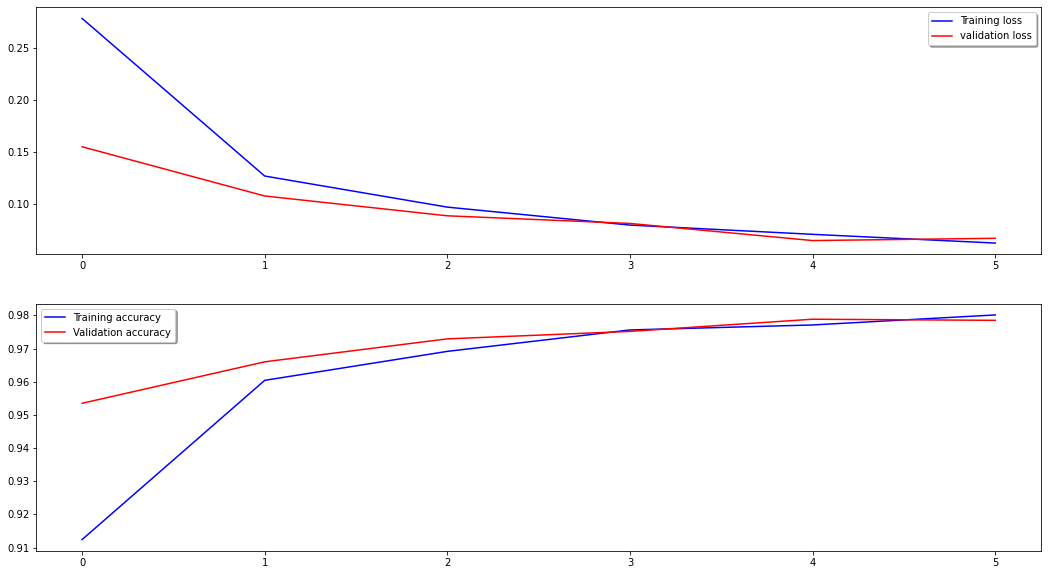

In [25]:
plot_history(best_tuned_history)

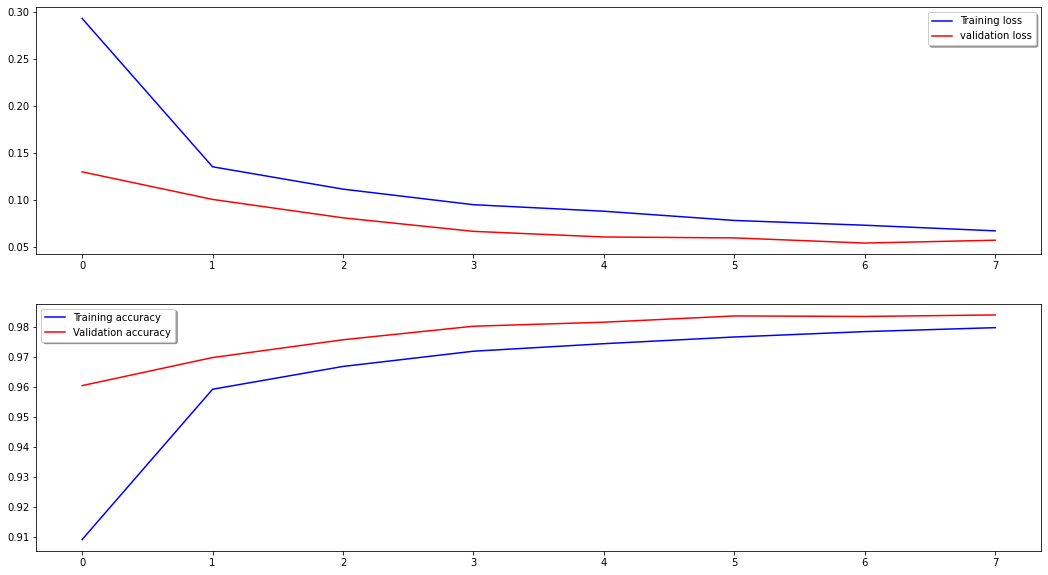

In [26]:
plot_history(keras_history)

In [27]:
def evaluate_model(in_model: None, iterator: None, print_result=False):
    step_size = iterator.n // iterator.batch_size
    verb = -1

    if print_result:
        verb = 1

    iterator.reset()

    ls, acc = in_model.evaluate(iterator, steps=step_size, verbose=verb)

    if print_result:
        print("Loss:\t\t{:.6f}\nAccuracy:\t{:.6f}".format(ls, acc))
    else:
        return ls, acc


In [28]:
evaluate_model(best_tuned_model, test_iterator, True)

10000/10000 [==============================] - 41s 4ms/step - loss: 0.0407 - accuracy: 0.9874
Loss:		0.040655
Accuracy:	0.987400


In [29]:
evaluate_model(keras_model, test_iterator, True)

10000/10000 [==============================] - 13s 1ms/step - loss: 0.0265 - accuracy: 0.9914
Loss:		0.026538
Accuracy:	0.991400


Тренированая модель показала худшую точность, что не радует. Но обучилась на две эпохи быстрее.

**Реальные цифры**

In [30]:
true_img_generator = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    rescale=1.0/255.0
)

#test_generator.fit(X_test)
true_img_iterator = true_img_generator.flow_from_directory(
    directory="./data",
    target_size=(28, 28),
    color_mode="grayscale",
    batch_size=1,
    class_mode="categorical"
)

Found 10 images belonging to 10 classes.


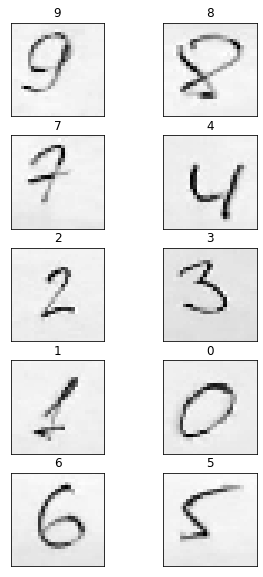

In [31]:
true_img_iterator.reset()

fig, ax = plt.subplots(5, 2, figsize=(5, 10))
axs = ax.flatten()

for idx in range(len(axs)):
    axs[idx].imshow(np.reshape(true_img_iterator[idx][0], (28, 28, 1)), cmap='gray_r')
    #axs[idx].imshow(true_img_iterator[idx][0])
    
    img_label = np.nonzero(true_img_iterator[idx][1][0])
    
    axs[idx].set_title(int(img_label[0]))

    axs[idx].xaxis.set_ticks([])
    axs[idx].yaxis.set_ticks([])

plt.show()

In [32]:
true_img_iterator.reset()

evaluate_model(best_tuned_model, true_img_iterator, True)

10/10 [==============================] - 0s 4ms/step - loss: 0.8509 - accuracy: 0.9000
Loss:		0.850946
Accuracy:	0.900000


In [33]:
true_img_iterator.reset()

evaluate_model(keras_model, true_img_iterator, True)

10/10 [==============================] - 0s 2ms/step - loss: 1.4676 - accuracy: 0.9000
Loss:		1.467583
Accuracy:	0.900000


Loss на тренированной модели меньше. 

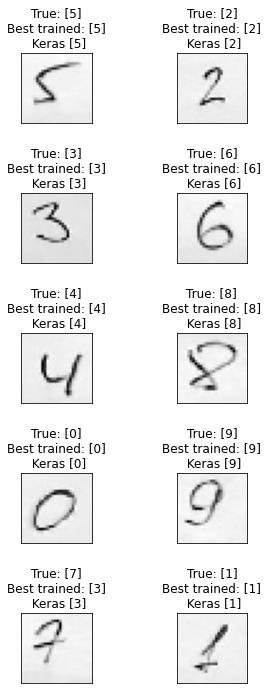

In [34]:
true_img_iterator.reset()

fig, ax = plt.subplots(5, 2, figsize=(5, 10))
axs = ax.flatten()

for idx in range(len(true_img_iterator)):
    best_model_predict = best_tuned_model.predict(true_img_iterator[idx][0]).argmax(-1)
    keras_model_predict = keras_model.predict(true_img_iterator[idx][0]).argmax(-1)
    ground_true = np.nonzero(true_img_iterator[idx][1])[1]

    axs[idx].imshow(np.reshape(true_img_iterator[idx][0], (28, 28, 1)), cmap='gray_r')
    
    axs[idx].set_title("True: {}\nBest trained: {}\n Keras {}".format(ground_true, best_model_predict, keras_model_predict))

    axs[idx].xaxis.set_ticks([])
    axs[idx].yaxis.set_ticks([])

plt.tight_layout(pad=2.0)
plt.show()

Как видно, семерка вобще не хочет определяться. Можно бы было перетренировать модели, но я не вижу в этом смысла. Предварительно могу сказать, это связанно с тем, что в датасете почти все семерки без горизонтальной линии.

**Заключение**

Чем сетка проще, тем лучше. Inference быстрее, обучение быстрее. Тот случай, когда кашу маслом легко испортить. Как показал эксперимент точность может упасть, а производительность вырасти.

Подбор гиперпараметров тут тоже не панацея. Сетки нужно понимать.

Аугментация данных важный момент. Для картинок точно. Сетка без аугментации половину реальных цифр не узнала (этот эксперимент я не сохранил). 

Важность ранней остановки трудно недооценить. Это не только время, но и переобучение. Можно оставить сетку учится и не заметить, где она в оверфит ушла. 

Вобще callbacks это must have технология для применения в нейронках.

Tensorflow порадовал сохранением данных самостоятельно. Можно прервать обучение и не проводить его заново с нуля - очень удобно.

Большой (возможно единственный), конечно, минус нейронок это скорость. Что обучения, что inference. Но, безусловно, нелинейность заложенная изначально в саму идею творит чудеса.